Epoch 0, Loss: 0.431735
Epoch 10, Loss: 0.368061
Epoch 20, Loss: 0.285990
Epoch 30, Loss: 0.155865
Epoch 40, Loss: 0.043108
Epoch 50, Loss: 0.027097
Epoch 60, Loss: 0.013739
Epoch 70, Loss: 0.012602
Epoch 80, Loss: 0.009916
Epoch 90, Loss: 0.008744


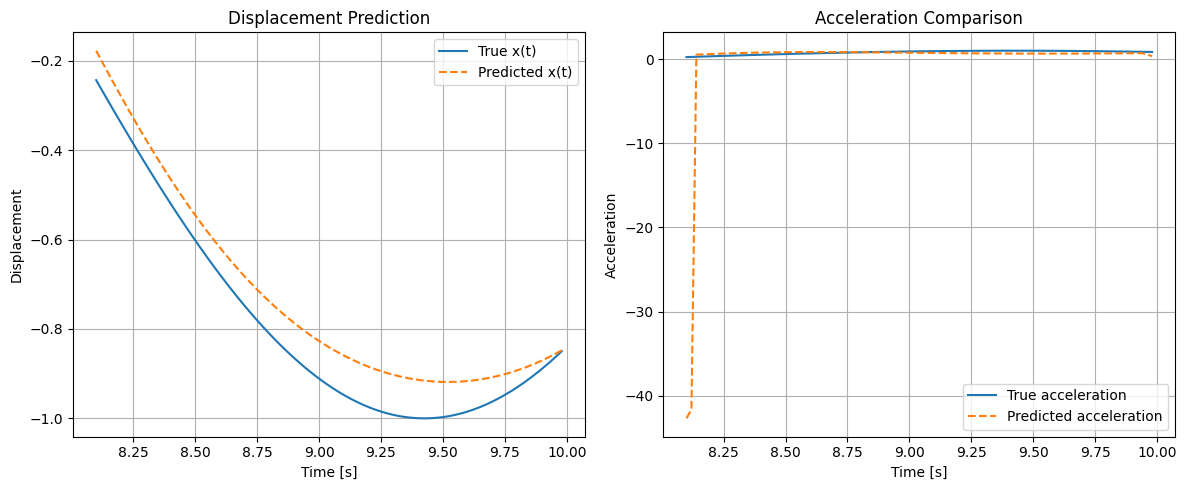

In [28]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 固定种子
torch.manual_seed(0)
np.random.seed(0)

# 解析解与加速度
def analytical_solution(t):
    return np.cos(t)

def analytical_acceleration(t):
    return -np.cos(t)

# 构造数据（0~10s，步长0.02）
dt = 0.02
t = np.arange(0, 10, dt)
x = analytical_solution(t)
a = analytical_acceleration(t)

# 构造LSTM序列
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 25
X, y = create_sequences(x, window_size)
a_seq = a[window_size:]

# 划分训练（0~8s）和测试（8~10s）
split_idx = int(8 / 10 * len(X))
# 训练集
X_train, y_train = X[:split_idx], y[:split_idx]
# 测试集
X_test, y_test = X[split_idx:], y[split_idx:]
a_test = a_seq[split_idx:]

# 转换为tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# 模型
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 32, batch_first=True)
        self.fc = nn.Linear(32, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 训练
for epoch in range(100):
    model.train()
    pred = model(X_train_tensor)
    loss = loss_fn(pred, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# 预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().numpy()

# 拼接预测数据并用中心差分法求加速度
x_pred_full = np.concatenate([x[:split_idx + window_size], y_pred])
a_pred = np.gradient(np.gradient(x_pred_full, dt), dt)[-len(y_pred):]
t_test = t[split_idx + window_size:]

# 画图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t_test, y_test, label='True x(t)')
plt.plot(t_test, y_pred, '--', label='Predicted x(t)')
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.title('Displacement Prediction')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_test, a_test, label='True acceleration')
plt.plot(t_test, a_pred, '--', label='Predicted acceleration')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration')
plt.title('Acceleration Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch 0, Loss: 0.431735
Epoch 10, Loss: 0.368061
Epoch 20, Loss: 0.285990
Epoch 30, Loss: 0.155865
Epoch 40, Loss: 0.043108
Epoch 50, Loss: 0.027097
Epoch 60, Loss: 0.013739
Epoch 70, Loss: 0.012602
Epoch 80, Loss: 0.009916
Epoch 90, Loss: 0.008744


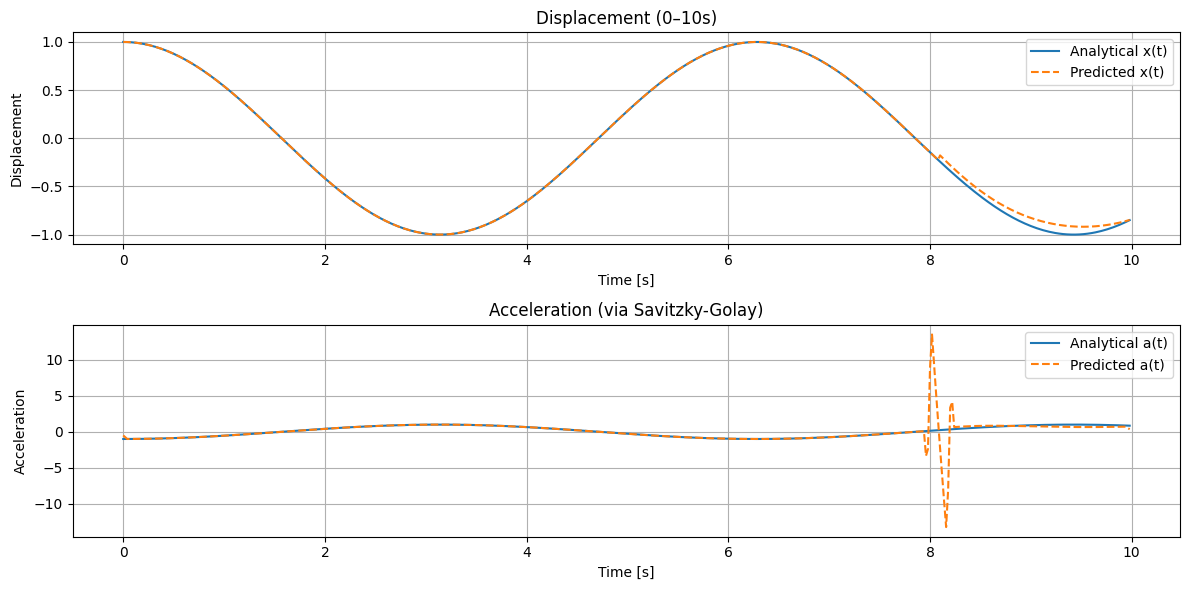

In [29]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# 固定种子
torch.manual_seed(0)
np.random.seed(0)

# 构造解析解
def analytical_solution(t): return np.cos(t)
def analytical_acceleration(t): return -np.cos(t)

# 时间和数据
dt = 0.02
t = np.arange(0, 10, dt)
x = analytical_solution(t)
a = analytical_acceleration(t)

# 构造滑动窗口序列
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 25
X_seq, y_seq = create_sequences(x, window_size)
t_seq = t[window_size:]

# 划分训练与测试
split_idx = int(8 / 10 * len(X_seq))
X_train, y_train = X_seq[:split_idx], y_seq[:split_idx]
X_test, y_test = X_seq[split_idx:], y_seq[split_idx:]
t_train_seq = t_seq[:split_idx]
t_test_seq = t_seq[split_idx:]
a_test_seq = a[window_size:][split_idx:]

# 转为 tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

# LSTM模型定义
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 32, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 模型训练
for epoch in range(100):
    model.train()
    y_pred_train = model(X_train_tensor)
    loss = loss_fn(y_pred_train, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# 预测 8–10s 位移
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).squeeze().numpy()

# 构建完整的预测序列（0–8s 使用真实数据，8–10s 使用预测）
x_pred_full = np.concatenate([x[:window_size + split_idx], y_pred_test])
t_pred_full = t[:len(x_pred_full)]

# Savitzky-Golay 滤波并求导
x_smooth = savgol_filter(x_pred_full, window_length=11, polyorder=3)
a_pred_smooth = np.gradient(np.gradient(x_smooth, dt), dt)

# 原始加速度（用于对比）
a_full = analytical_acceleration(t_pred_full)

# 绘图
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, x, label='Analytical x(t)')
plt.plot(t_pred_full, x_pred_full, '--', label='Predicted x(t)')
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.title('Displacement (0–10s)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_pred_full, a_full, label='Analytical a(t)')
plt.plot(t_pred_full, a_pred_smooth, '--', label='Predicted a(t)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration')
plt.title('Acceleration (via Savitzky-Golay)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch 0, Loss: 0.481757, MSE: 0.481757, Phys: 0.000000
Epoch 50, Loss: 0.012906, MSE: 0.012906, Phys: 0.000000
Epoch 100, Loss: 0.003415, MSE: 0.003415, Phys: 0.000000
Epoch 150, Loss: 0.002153, MSE: 0.002153, Phys: 0.000000
Epoch 200, Loss: 0.001582, MSE: 0.001581, Phys: 0.000000
Epoch 250, Loss: 0.001157, MSE: 0.001157, Phys: 0.000000


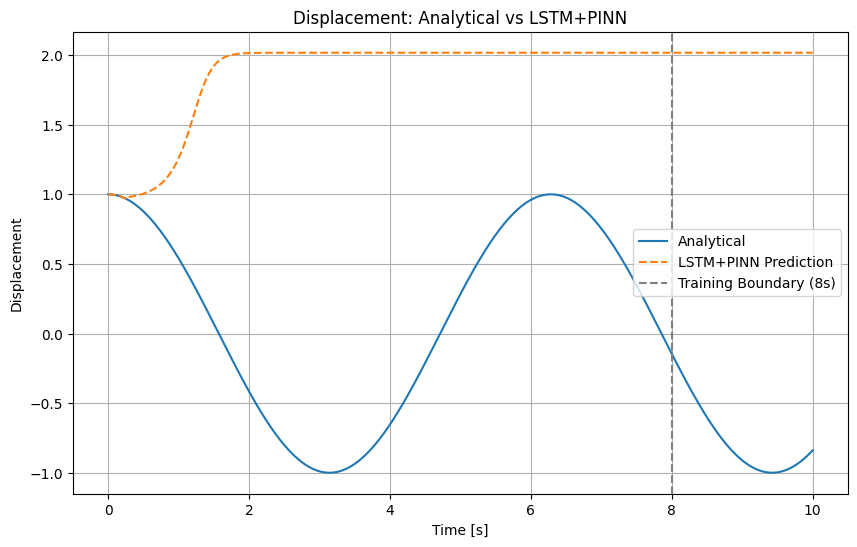

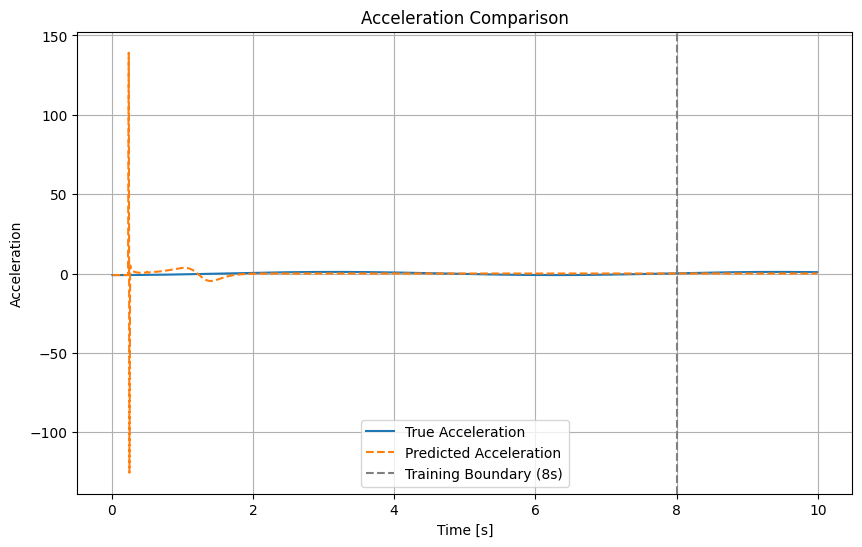

: 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 构造弹簧振子的位移数据
def analytical_solution(t, x0=1.0, v0=0.0):
    return x0 * np.cos(t) + v0 * np.sin(t)

t_total = np.linspace(0, 10, 1001)
x_total = analytical_solution(t_total)

# 超参数
window_size = 25
train_until = 800  # 0–8s 训练 (1000个点 -> 第800个是8秒)
lambda_phys = 0.1  # 物理损失权重

# 构造 LSTM 输入窗口
def create_sequences(data, window):
    x, y = [], []
    for i in range(len(data) - window):
        x.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(x), np.array(y)

x_input, x_output = create_sequences(x_total, window_size)

# 划分训练/测试集
X_train = torch.tensor(x_input[:train_until], dtype=torch.float32).unsqueeze(-1).to(device)
y_train = torch.tensor(x_output[:train_until], dtype=torch.float32).unsqueeze(-1).to(device)
X_test = torch.tensor(x_input[train_until:], dtype=torch.float32).unsqueeze(-1).to(device)

# 定义模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

# 中心差分求加速度
def central_diff(x_seq, dt):
    return (x_seq[:, 2:] - 2*x_seq[:, 1:-1] + x_seq[:, :-2]) / (dt**2)

# 训练模型
epochs = 300
dt = t_total[1] - t_total[0]

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(X_train)

    # 标准损失
    loss_pred = mse_loss(y_pred, y_train)

    # 物理损失部分（只对最后一个时间窗口做加速度约束）
    # 拼接预测结果作为新的序列尾部
    with torch.no_grad():
        x_seq = X_train[:, :, 0]  # 原始序列 shape: (batch, 25)
        # 使用最后 23 个点 + 1 个预测点组成 24 长度序列
        x_last = torch.cat([x_seq[:, -window_size+2:], y_pred.squeeze(-1).unsqueeze(1)], dim=1)
    # print("x_last.shape=", x_last.shape): torch.Size([800, 24])
    
    # 中心差分：结果为 (batch, 22)
    acc_pred = central_diff(x_last.unsqueeze(0), dt).squeeze(0)
    # print("acc_pred.shape=", acc_pred.shape): torch.Size([798, 24])

    acc_pred_ = acc_pred[:, 1:-1]
    # print("acc_pred_.shape=", acc_pred_.shape): torch.Size([798, 22])
    

    # 对应的 x 值也只取中间 22 个位置
    x_phys = x_last[1:-1, 1:-1]
    # print("x_phys.shape=", x_phys.shape): torch.Size([798, 22])

    # 物理残差损失
    loss_phys = mse_loss(acc_pred_ + x_phys, torch.zeros_like(acc_pred_))


    # 总损失
    loss = loss_pred + lambda_phys * loss_phys
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, MSE: {loss_pred.item():.6f}, Phys: {loss_phys.item():.6f}")

# 预测阶段
model.eval()
x_pred = x_total[:window_size].tolist()

with torch.no_grad():
    for i in range(window_size, 1001):
        seq = torch.tensor(x_pred[-window_size:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
        next_val = model(seq).item()
        x_pred.append(next_val)

x_pred = np.array(x_pred)

# 使用中心差分计算加速度
a_true = (x_total[2:] - 2*x_total[1:-1] + x_total[:-2]) / dt**2
a_pred = (x_pred[2:] - 2*x_pred[1:-1] + x_pred[:-2]) / dt**2
t_acc = t_total[1:-1]

# 画图对比
plt.figure(figsize=(10,6))
plt.plot(t_total, x_total, label='Analytical')
plt.plot(t_total, x_pred, '--', label='LSTM+PINN Prediction')
plt.axvline(8, color='gray', linestyle='--', label='Training Boundary (8s)')
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.title('Displacement: Analytical vs LSTM+PINN')
plt.legend()
plt.grid(True)
plt.show()

# 画加速度
plt.figure(figsize=(10,6))
plt.plot(t_acc, a_true, label='True Acceleration')
plt.plot(t_acc, a_pred, '--', label='Predicted Acceleration')
plt.axvline(8, color='gray', linestyle='--', label='Training Boundary (8s)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration')
plt.title('Acceleration Comparison')
plt.legend()
plt.grid(True)
plt.show()